In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
class CPCSVDataset(Dataset):
    def __init__(self, csv_paths):
        self.data = []  # 각 subject에 대한 데이터 저장
        # 각 CSV 파일별로 읽어서 처리
        for path in csv_paths:
            df = pd.read_csv(path, index_col=0)  # 첫번째 컬럼은 인덱스이므로 제거
            # subject별 그룹화 (ID 기준)
            grouped = df.groupby("ID")
            for subject_id, group in grouped:
                # 시간 값이 중복되는 경우 제거하여 strictly increasing하게 만듭니다.
                group = group.sort_values("time").drop_duplicates(subset="time")
                static_features = (
                    group[["BW", "EGFR", "SEX", "RAAS", "BPS", "amt", "II"]]
                    .iloc[0]
                    .values.astype(np.float32)
                )
                times = group["time"].values.astype(np.float32)
                cp_values = group["CP"].values.astype(np.float32)
                static_features = torch.tensor(static_features)
                times = torch.tensor(times)
                cp_values = torch.tensor(cp_values)
                self.data.append((static_features, times, cp_values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# CSV 파일 경로 리스트 (i = 1 ~ 3)
csv_paths = [
    os.path.join("..", "Data files", "1_data files", f"result_{i}.csv")
    for i in range(1, 4)
]
dataset = CPCSVDataset(csv_paths)
print(f"Loaded {len(dataset)} subjects from CSV files.")

Loaded 3 subjects from CSV files.


In [11]:
# ODE 함수: 은닉 상태의 연속적인 변화율 학습
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
        )

    def forward(self, t, h):
        return self.net(h)


# Neural ODE를 활용한 CP 예측 모델
class NeuralODECP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        input_dim: 정적 피처 차원 (여기서는 7)
        hidden_dim: 은닉 상태 차원
        output_dim: CP 예측 출력 차원 (보통 1)
        """
        super(NeuralODECP, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.odefunc = ODEFunc(hidden_dim)
        self.fc_cp = nn.Linear(hidden_dim, output_dim)  # 각 시간 스텝에서 CP 예측

    def forward(self, static_input, times):
        # static_input: [B, input_dim]
        h0 = self.fc_in(static_input)  # 초기 은닉 상태, [B, hidden_dim]
        # ODE 솔버로 연속 시간상의 은닉 상태 계산 (times: [T])
        # 결과 h_ts: [T, B, hidden_dim]
        h_ts = odeint(self.odefunc, h0, times)
        # [B, T, hidden_dim]로 전치
        h_ts = h_ts.transpose(0, 1)
        # 각 시간 스텝마다 선형 변환 → [B, T, output_dim]
        cp_pred = self.fc_cp(h_ts)
        return cp_pred

In [12]:
def train(model, dataset, n_epochs=100, batch_size=4, lr=1e-3, device="cpu"):
    model.to(device)
    # 주의: 각 subject마다 시간 벡터 길이가 동일하다고 가정합니다.
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: batch
    )
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    epoch_losses = []

    for epoch in range(n_epochs):
        total_loss = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            batch_loss = 0.0
            # 배치 내 각 샘플을 개별적으로 처리합니다.
            for static_input, times, cp_target in batch:
                static_input = static_input.unsqueeze(0).to(device)  # [1, input_dim]
                times = times.to(device)  # [T]
                cp_target = cp_target.to(device)  # [T]
                cp_pred = model(static_input, times)  # [1, T, 1]
                cp_pred = cp_pred.squeeze(0).squeeze(-1)  # [T]
                loss = criterion(cp_pred, cp_target)
                batch_loss += loss
            batch_loss /= len(batch)
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()
        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    return epoch_losses

Epoch 1/10, Loss: 102600.1641
Epoch 2/10, Loss: 49641.0742
Epoch 3/10, Loss: 24482.1719
Epoch 4/10, Loss: 21177.4629
Epoch 5/10, Loss: 27259.5371
Epoch 6/10, Loss: 28540.6270
Epoch 7/10, Loss: 24072.6348
Epoch 8/10, Loss: 14726.6523
Epoch 9/10, Loss: 8596.2783
Epoch 10/10, Loss: 7076.3745


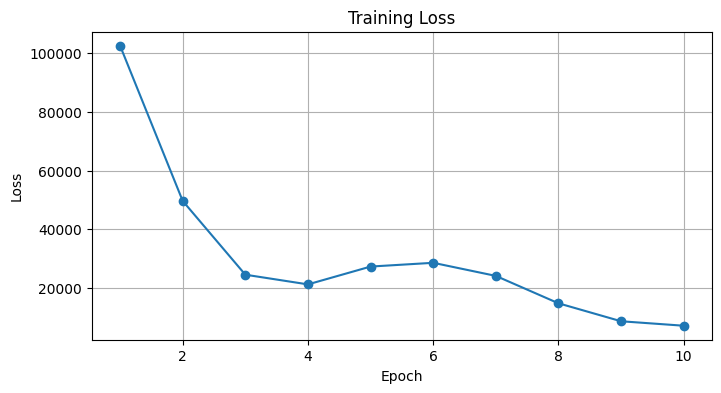

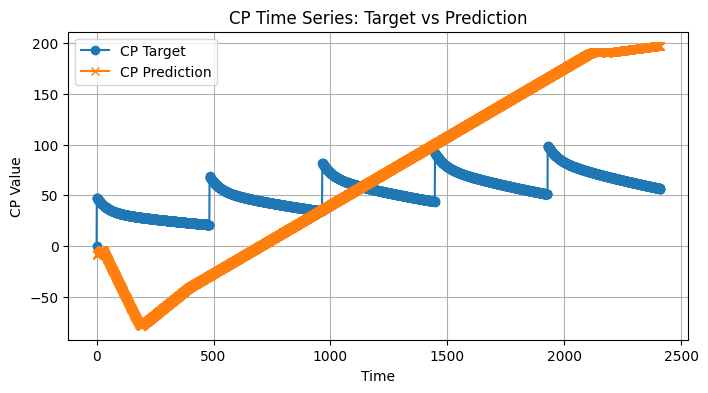

In [14]:
# 학습에 사용할 device 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 생성: input_dim=7 (정적 피처), hidden_dim은 16, output_dim=1 (CP 예측)
model = NeuralODECP(input_dim=7, hidden_dim=16, output_dim=1)

# 모델 학습
epoch_losses = train(model, dataset, n_epochs=10, batch_size=4, lr=1e-3, device=device)

# 학습 손실 변화 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# 임의의 subject 하나 선택하여 예측 결과 비교
import random

model.eval()
subject_idx = random.randint(0, len(dataset) - 1)
static_input, times, cp_target = dataset[subject_idx]
static_input = static_input.unsqueeze(0).to(device)  # 배치 차원 추가
times = times.to(device)
with torch.no_grad():
    cp_pred = model(static_input, times)  # [1, T, 1]
cp_pred = cp_pred.squeeze().cpu().numpy()  # [T]
times_np = times.cpu().numpy()
cp_target_np = cp_target.cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(times_np, cp_target_np, label="CP Target", marker="o")
plt.plot(times_np, cp_pred, label="CP Prediction", marker="x")
plt.xlabel("Time")
plt.ylabel("CP Value")
plt.title("CP Time Series: Target vs Prediction")
plt.legend()
plt.grid(True)
plt.show()